# Example: Multivariate Normal distribution.

For more information of the MND please visit: https://en.wikipedia.org/wiki/Multivariate_normal_distribution

In [1]:
# General imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specific imports.
from scipy.optimize import approx_fprime
from scipy.stats import multivariate_normal


# Import local HMC implementation.
from src.hmc_sampler import HMC

In [2]:
# Setup three 2D Gaussian funcitons.
# Each one with different mean and covariance matrix.
rv_1 = multivariate_normal([-0.0, -1.0], [[1.0, 0.1],
                                          [0.1, 1.0]])

rv_2 = multivariate_normal([-4.0, -6.0], [[0.9, 0.2],
                                          [0.2, 0.9]])

rv_3 = multivariate_normal([-5.0, +1.0], [[1.2, 0.3],
                                          [0.3, 1.2]])

# Define the negative log of the pdf we want to sample.
# Here we have the sum of the three Gaussians (with equal weights).
def _neg_log_pdfx(x):
    return -np.log(rv_1.pdf(x) +
                   rv_2.pdf(x) +
                   rv_3.pdf(x))
# _end_def_

# We define the gradient of the -log(pdf). We can estimate it analytically
# or use finite difference method to get it numerically. This approach is
# slower.
def _grad(x):
    return approx_fprime(x, _neg_log_pdfx,  epsilon=1.5e-08)
# _end_def_

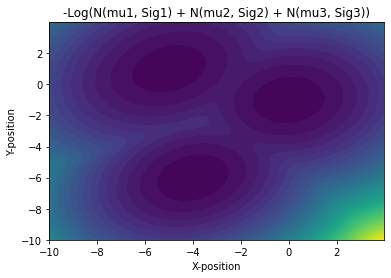

In [3]:
# Prepare the plot of the real density.
x, y = np.mgrid[-10:4:.01, -10:4:.01]

pos = np.dstack((x, y))

plt.contourf(x, y, _neg_log_pdfx(pos), levels=40);
plt.xlabel("X-position")
plt.ylabel("Y-position")
plt.title("-Log(N(mu1, Sig1) + N(mu2, Sig2) + N(mu3, Sig3))");

In [11]:
# Create an HMC object.
gauss2D_hmc = HMC(_neg_log_pdfx, _grad, n_omitted=500, n_samples=5_000,
                  verbose=True, grad_check=True, rng_seed=911,
                  kappa=50, d_tau=0.02)

# Print out the settings.
print(gauss2D_hmc)

 HMC Id(4929352192): 
 Func(x)=<function _neg_log_pdfx at 0x1208741f0> 
 Grad(x)=<function _grad at 0x120874280> 
 Options:
 	n_samples: 5000
	n_omitted: 500
	kappa: 50
	d_tau: 0.02
	grad_check: True
	generalized: False
	verbose: True
	rng_seed: RandomState(MT19937)



In [12]:
# Run the sampling from x0 starting point.
results = gauss2D_hmc(x0=[-4.0, -4.0])

Checking gradients <BEFORE> sampling ... 
Error <BEFORE> = 1.0282814458496972e-07
 >>> HMC started 


 Iter=4500 - E=1.940 - Acceptance=1.000: 100%|██████████| 5500/5500 [02:36<00:00, 35.06it/s]

 >>> HMC finished in 156.878 seconds.
Checking gradients <AFTER> sampling ... 
Error <AFTER> = 1.087806614704814e-08


In [13]:
# It is easier to convert the data directly to pandas.
df = pd.DataFrame(results["Samples"])

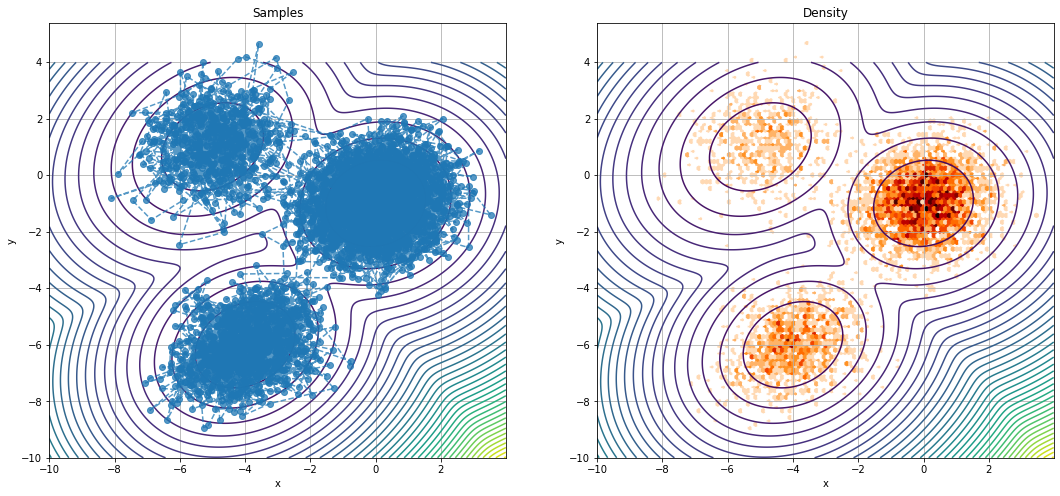

In [14]:
# Create a large figure.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

ax[0].contour(x, y, _neg_log_pdfx(pos), levels=40);
ax[0].plot(df[0], df[1], 'o--', alpha=0.75);
ax[0].set_xlabel("x"); ax[0].set_ylabel("y");
ax[0].grid(True); ax[0].set_title("Samples");

ax[1].contour(x, y, _neg_log_pdfx(pos), levels=40);
ax[1].hexbin(df[0], df[1], bins=80, cmap='gist_heat_r');
ax[1].set_xlabel("x"); ax[1].set_ylabel("y");
ax[1].grid(True); ax[1].set_title("Density");

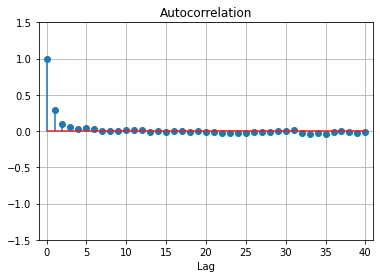

In [15]:
# ACF lag value.
lag_n = 40

# Plot the ACF.
plt.stem(gauss2D_hmc.acf(lag_n=lag_n));

plt.grid(True);

plt.title("Autocorrelation");

plt.xlim([-1, lag_n+1])

plt.ylim([-1.5, 1.5])

plt.xticks(range(0, lag_n+1, 5))

plt.xlabel("Lag");